In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [23]:
# Loading data
df = pd.read_csv('Datasets/balanced_augmented_NewDepartments_dataset.csv')
print(df.shape)

(420, 2)


In [24]:
df.head(3).T #Display First 3 lines

,0,1,2
Complaints,I have a phone connection also in this number ...,My internet speed is much slower than what I'm...,I need to just make it a high priority because...
Department,Technical,Technical,Technical


In [25]:
pd.DataFrame(df.Department.unique()).values #Get unique values in department column

array([['Technical'],
       ['Billing'],
       ['HR']], dtype=object)

In [26]:
# Create a new column 'department_id' with encoded Departments
df2 = df.sample(420, random_state=1).copy()
df2['department_id'] = df2['Department'].factorize()[0]
department_id_df = df2[['Department', 'department_id']].drop_duplicates()
# Dictionaries for future use
department_to_id = dict(department_id_df.values)
id_to_department = dict(department_id_df[['department_id', 'Department']].values)
# New dataframe
df2.head()

,Complaints,Department,department_id
378,The representative was unprofessional during o...,HR,0
165,Is it not possibly a disconnection due to loss...,Billing,1
17,"I frequently travel to a specific area, and th...",Technical,2
179,There are some fees on my bill that weren't di...,Billing,1
4,"I want to log a complaint that my internet, TV...",Technical,2


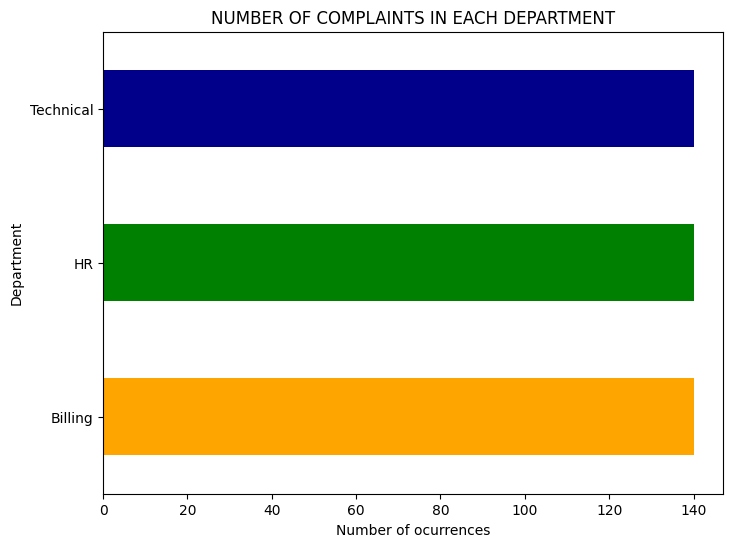

In [27]:
#Plot to see number of complaints in each department
ig = plt.figure(figsize=(8,6))
colors = ['orange','green','darkblue',]
df2.groupby('Department').Complaints.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH DEPARTMENT')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [28]:
# Define features and labels
features = df2['Complaints']
labels = df2['department_id']

# TF-IDF vectorization
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')
features_tfidf = tfidf.fit_transform(features).toarray()

In [29]:
# Model selection and cross-validation
models = [RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)]
CV = 4
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features_tfidf, labels, scoring='accuracy', cv=CV)

    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# Display cross-validation results
print("Cross-validation results:")
print(cv_df)

Cross-validation results:
               model_name  fold_idx  accuracy
0  RandomForestClassifier         0  0.761905
1  RandomForestClassifier         1  0.752381
2  RandomForestClassifier         2  0.895238
3  RandomForestClassifier         3  0.838095


In [30]:
# Grid Search
rf_model = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=4)
grid_search.fit(features_tfidf, labels)

# Display best parameters and accuracy from grid search
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy:  0.9380952380952381


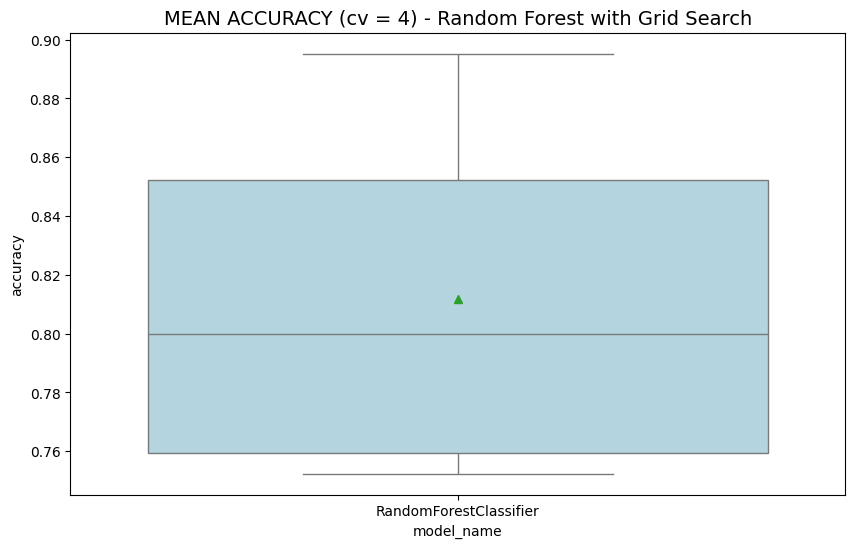

In [31]:
# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df, color='lightblue', showmeans=True)
plt.title("MEAN ACCURACY (cv = 4) - Random Forest with Grid Search", size=14)
plt.show()

In [32]:
# Train the best model on the entire dataset
best_rf_model = grid_search.best_estimator_

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_tfidf, labels, test_size=0.25, random_state=0)

# Train the model on the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

In [33]:
# Classification report
print('\nCLASSIFICATION METRICS')
print(metrics.classification_report(y_test, y_pred, target_names=df2['Department'].unique()))


CLASSIFICATION METRICS
              precision    recall  f1-score   support

          HR       0.97      0.97      0.97        33
     Billing       1.00      0.86      0.93        37
   Technical       0.85      0.97      0.91        35

    accuracy                           0.93       105
   macro avg       0.94      0.94      0.93       105
weighted avg       0.94      0.93      0.93       105



In [34]:
complaint = """I need charges in my bill"""

# Transform the new complaint using the same TF-IDF vectorizer
complaint_tfidf = tfidf.transform([complaint]).toarray()

# Make predictions using the best_rf_model
prediction_id = best_rf_model.predict(complaint_tfidf)

# Inverse transform the predicted label to get the department name
prediction_name = id_to_department[prediction_id[0]]

print(prediction_name)


Billing


In [35]:
complaint = """One of your agent was so rude to me"""
# Transform the new complaint using the same TF-IDF vectorizer
complaint_tfidf = tfidf.transform([complaint]).toarray()

# Make predictions using the best_rf_model
prediction_id = best_rf_model.predict(complaint_tfidf)

# Inverse transform the predicted label to get the department name
prediction_name = id_to_department[prediction_id[0]]

print(prediction_name)


HR


In [36]:
complaint = """I was billed for a service i cancelled last year"""
# Transform the new complaint using the same TF-IDF vectorizer
complaint_tfidf = tfidf.transform([complaint]).toarray()

# Make predictions using the best_rf_model
prediction_id = best_rf_model.predict(complaint_tfidf)

# Inverse transform the predicted label to get the department name
prediction_name = id_to_department[prediction_id[0]]

print(prediction_name)


Billing


In [37]:
complaint = """My data is not working and i can't send messages"""
# Transform the new complaint using the same TF-IDF vectorizer
complaint_tfidf = tfidf.transform([complaint]).toarray()

# Make predictions using the best_rf_model
prediction_id = best_rf_model.predict(complaint_tfidf)

# Inverse transform the predicted label to get the department name
prediction_name = id_to_department[prediction_id[0]]

print(prediction_name)


Technical


In [38]:
complaint = """Previous agent ignored my call and didn't gave me a proper response"""
# Transform the new complaint using the same TF-IDF vectorizer
complaint_tfidf = tfidf.transform([complaint]).toarray()

# Make predictions using the best_rf_model
prediction_id = best_rf_model.predict(complaint_tfidf)

# Inverse transform the predicted label to get the department name
prediction_name = id_to_department[prediction_id[0]]

print(prediction_name)


HR


In [39]:
complaint = """There have been consistent discrepancies in the charges reflected on my monthly statements.
Despite selecting a specific plan with clearly defined costs, I have noticed unauthorized fees and unexplained increases in my bills.
This lack of transparency has left me frustrated and confused about the actual charges for the services I am receiving."""
# Transform the new complaint using the same TF-IDF vectorizer
complaint_tfidf = tfidf.transform([complaint]).toarray()

# Make predictions using the best_rf_model
prediction_id = best_rf_model.predict(complaint_tfidf)

# Inverse transform the predicted label to get the department name
prediction_name = id_to_department[prediction_id[0]]

print(prediction_name)


Billing


In [40]:
complaint = """The customer service agent I spoke to demonstrated
a complete lack of empathy towards my concerns. Instead of actively listening
and understanding the issue, the agent seemed disinterested and indifferent."""

# Transform the new complaint using the same TF-IDF vectorizer
complaint_tfidf = tfidf.transform([complaint]).toarray()

# Make predictions using the best_rf_model
prediction_id = best_rf_model.predict(complaint_tfidf)

# Inverse transform the predicted label to get the department name
prediction_name = id_to_department[prediction_id[0]]

print(prediction_name)


HR


In [41]:
complaint = """Despite numerous attempts to troubleshoot the problem on my end, including resetting the router, checking for software updates,
and ensuring proper device configurations, the WiFi connection remains unstable and frequently disconnects. This has severely impacted my ability to work,
engage in online meetings, and enjoy a seamless internet experience."""
# Transform the new complaint using the same TF-IDF vectorizer
complaint_tfidf = tfidf.transform([complaint]).toarray()

# Make predictions using the best_rf_model
prediction_id = best_rf_model.predict(complaint_tfidf)

# Inverse transform the predicted label to get the department name
prediction_name = id_to_department[prediction_id[0]]

print(prediction_name)


Technical
